In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [3]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.utils import get_spark_session
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import numpy as np
import pandas as pd

/opt/miniconda3/envs/replay/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data

In [11]:
from kaggle.api.kaggle_api_extended import KaggleApi
DATASET_MAPPINGS = {
    "zvuk": {"kaggle": "alexxl/zvuk-dataset", "file": "zvuk-interactions.parquet"},
    "megamarket": {"kaggle": "alexxl/megamarket", "file": "megamarket.parquet"},
}
data_path = "replay_benchmarks/data/"
kaggle_info = DATASET_MAPPINGS['megamarket']
raw_data_file = os.path.join(data_path, kaggle_info["file"])

"""Download dataset from Kaggle."""
kaggle_dataset = kaggle_info["kaggle"]

os.environ.setdefault("KAGGLE_USERNAME", "recsysaccelerate")
os.environ.setdefault("KAGGLE_KEY", "6363e91b656fea576c39e4f55dcc1d00")

api = KaggleApi()
api.authenticate()

api.dataset_download_files(kaggle_dataset, path=data_path, unzip=True)
print(f"Dataset downloaded and extracted to {data_path}")

interactions = pd.read_parquet(raw_data_file)
interactions['timestamp'] = interactions[
    'datetime'
].astype("int64")

Dataset URL: https://www.kaggle.com/datasets/alexxl/megamarket
Dataset downloaded and extracted to replay_benchmarks/data/


In [12]:
interactions.head()

,user_id,datetime,event,item_id,category_id,price,timestamp
0,1199174,2023-02-13 03:12:19.131,2,1861088,5395,-0.042062,1676257939131
1,3124963,2023-02-13 09:38:55.674,2,2084441,1531,0.079817,1676281135674
2,2106055,2023-02-13 08:26:05.004,2,2586689,9294,-0.038990,1676276765004
3,4169844,2023-02-13 16:55:08.470,2,2586689,9294,-0.038990,1676307308470
4,7472260,2023-02-13 03:30:13.093,2,2586689,9294,-0.038990,1676259013093


In [13]:
interactions.event.value_counts()

event
2    118342938
0     52961163
3     19879157
1      5460762
Name: count, dtype: int64

In [14]:
interactions = interactions[interactions.event == 2]

In [15]:
interactions['price'].describe()

count    1.183429e+08
mean     1.934640e-02
std      1.287710e+00
min     -4.296196e-02
25%     -3.973579e-02
50%     -3.029587e-02
75%      1.072477e-02
max      9.852566e+03
Name: price, dtype: float64

In [16]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 367038
Number of unique items: 3281750


In [17]:
pd.to_datetime(interactions['timestamp'], unit='ms').describe()

count                        118342938
mean     2023-03-21 22:09:35.428196096
min         2023-01-15 00:00:00.708000
25%      2023-02-24 08:36:25.429250048
50%      2023-03-25 10:47:31.744499968
75%      2023-04-18 09:23:21.957749760
max         2023-05-14 20:00:15.513000
Name: timestamp, dtype: object

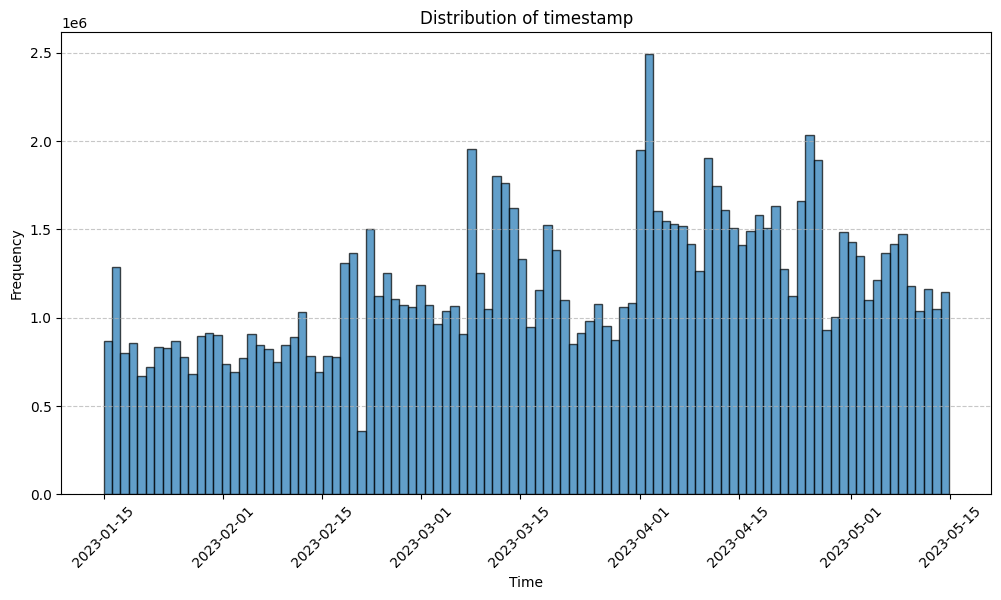

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ms', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [19]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 3


In [20]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 350267
Number of unique items: 1661327


In [21]:
# Number of unique users: 367038
# Number of unique items: 3281750

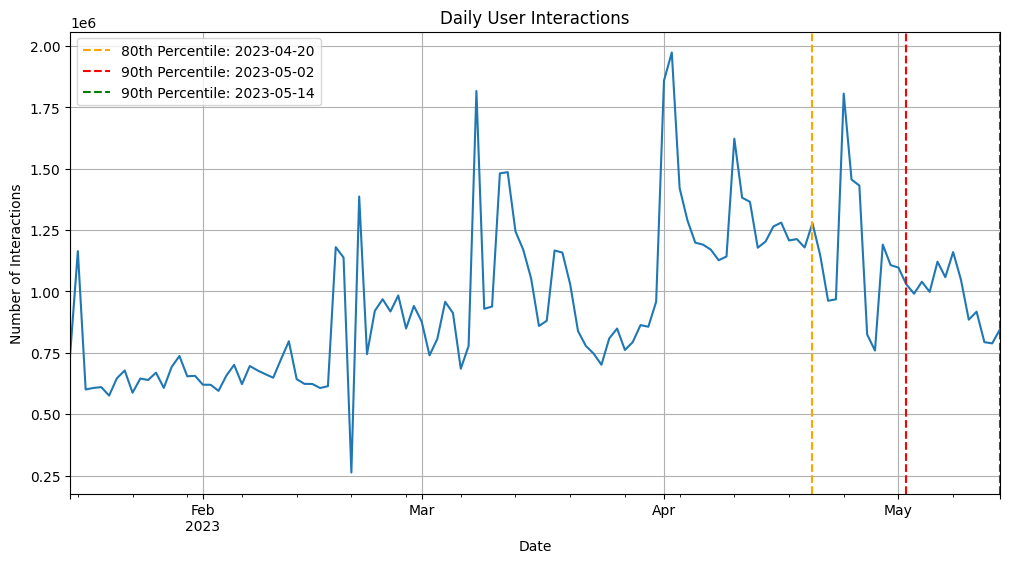

In [22]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ms')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'90th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    172257.000000
mean         57.367596
std         129.637846
min           1.000000
25%           4.000000
50%          16.000000
75%          52.000000
max        5585.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    184880.000000
mean         57.208151
std         126.197158
min           1.000000
25%           5.000000
50%          16.000000
75%          54.000000
max        4808.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    172257.000000
mean         42.268477
std          57.918843
min           1.000000
25%           4.000000
50%          16.000000
75%          52.000000
max         200.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    184880.000000
mean         43.096436
std          57.691051
min           1.000000
25%           5.000000
50%          16.000000
75%          54.000000
max         200.0

In [24]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [25]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [26]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 1575315
Number of unique query_ids: 172257


count    172257.000000
mean        450.985487
std         879.602123
min           1.000000
25%          58.000000
50%         175.000000
75%         468.000000
max       33304.000000
Name: item_id_seq, dtype: float64

In [27]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 606149
Number of unique query_ids: 172257


count    172257.000000
mean         42.268477
std          57.918843
min           1.000000
25%           4.000000
50%          16.000000
75%          52.000000
max         200.000000
Name: item_id_seq, dtype: float64

In [28]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 1585703
Number of unique query_ids: 184880


count    184880.000000
mean        475.492995
std         935.552190
min           1.000000
25%          62.000000
50%         182.000000
75%         487.000000
max       35973.000000
Name: item_id_seq, dtype: float64

In [29]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe()

Number of unique item_ids: 641885
Number of unique query_ids: 184880


count    184880.000000
mean         43.096436
std          57.691051
min           1.000000
25%           5.000000
50%          16.000000
75%          54.000000
max         200.000000
Name: item_id, dtype: float64

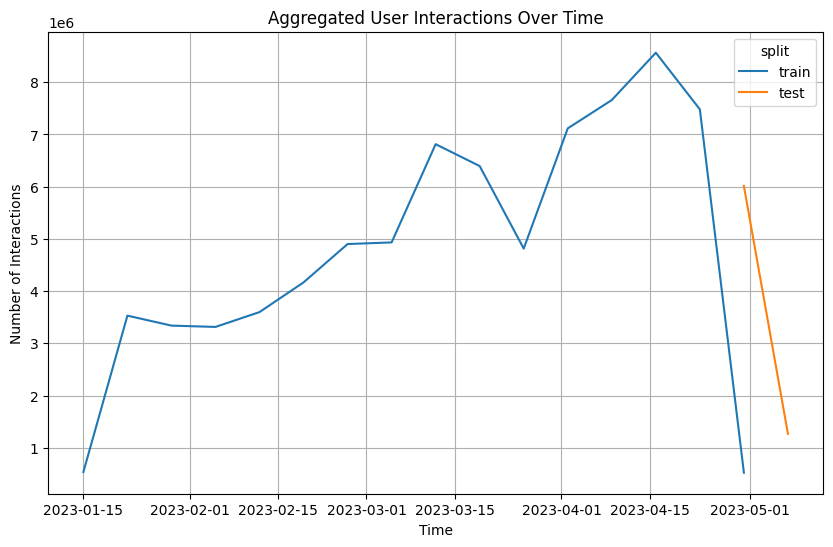

In [30]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

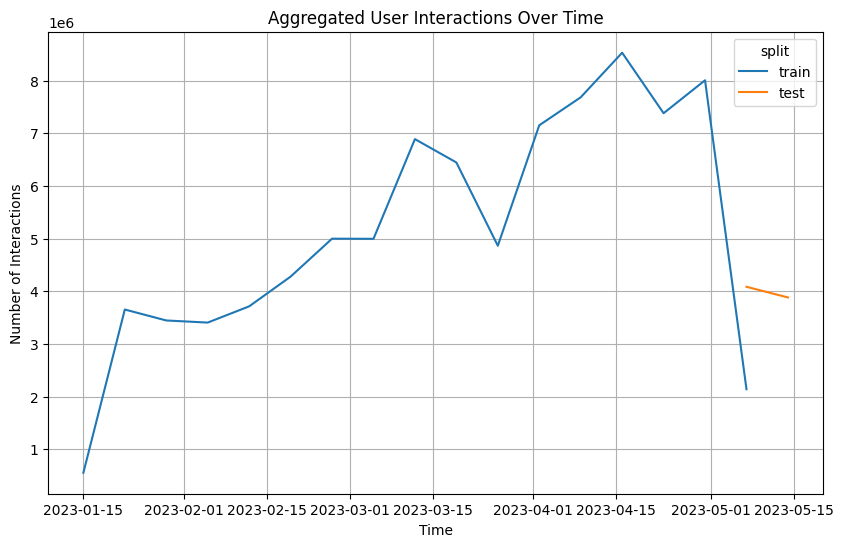

In [31]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

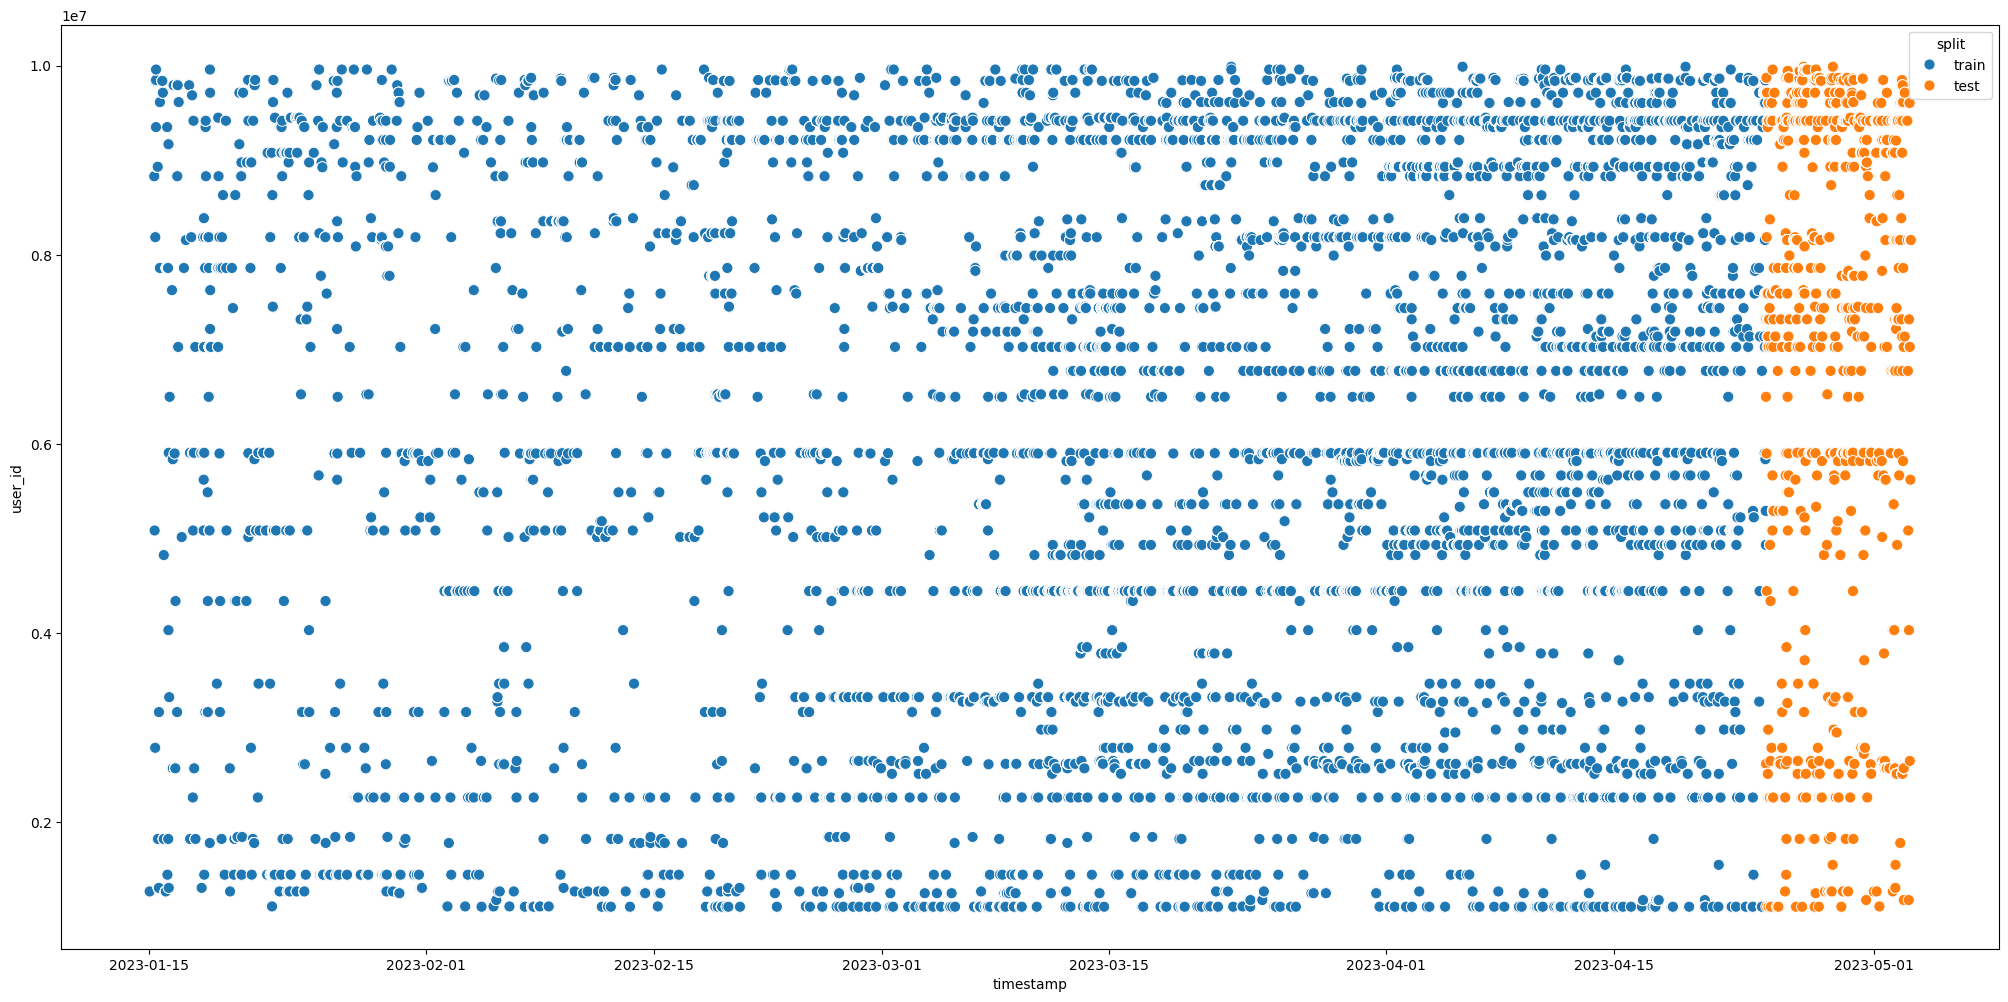

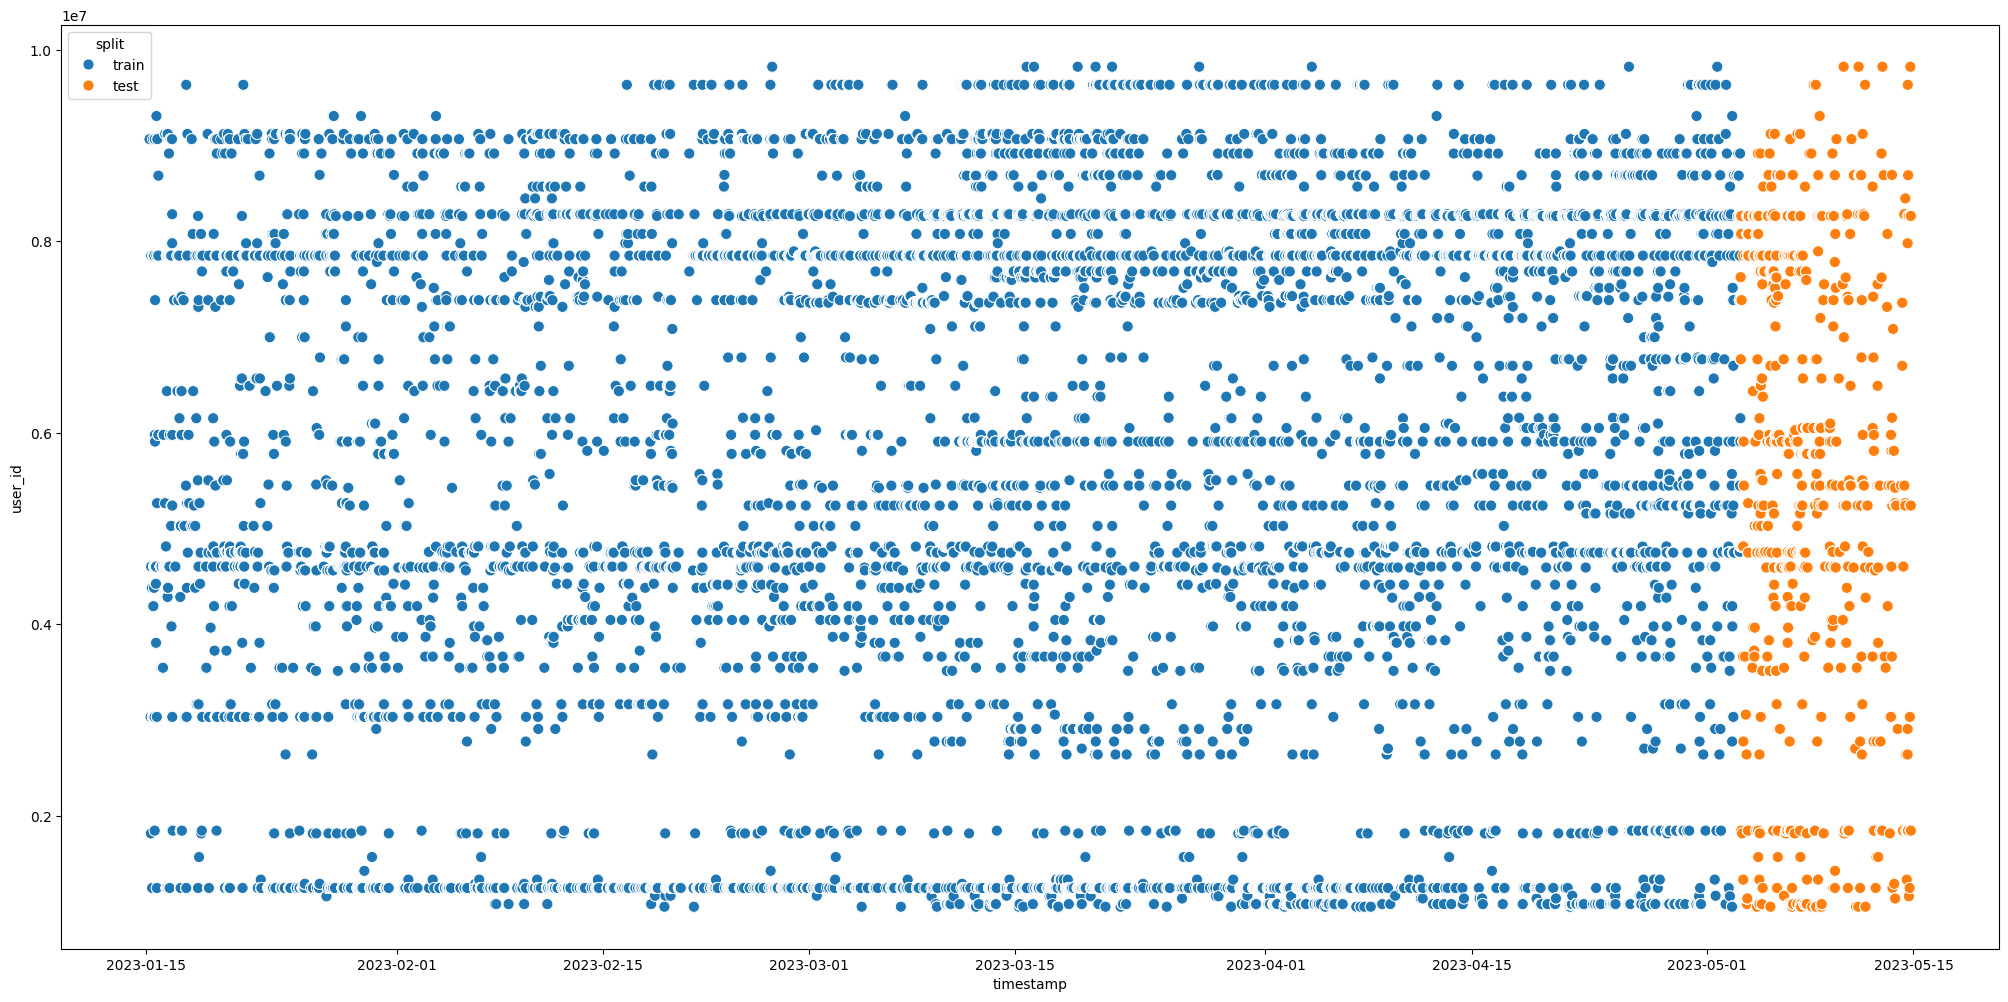

In [32]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)